In [1]:
# !pip install -e ../

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard libraries
import logging
import sys
import re

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import ast

import pudl
from pudl_ct.guts import *

mpl.style.use('dark_background')
pd.options.display.max_columns = None
plt.rcParams["figure.figsize"] = (15,10)

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

### Make Shared Inputs
These tables will be shared between both the coal and gas outputs. This is especially important for CEMS because it takes a minute to process the hourly data

In [5]:
# make the PUDL output object which will grab tables from the pudl db
# denormalize and cache outputs
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
# the fill_net_gen arg is employing a beta feature!
# It will result in a much higher coverage of net generation
# and fuel consuption, but it has known issues with multi-fuel plants.
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine,
    freq='AS',
    fill_fuel_cost=True,
    roll_fuel_cost=True,
    fill_net_gen=True,
    start_date='2017-01-01',
)

In [6]:
%%time
# this takes several minutes.. it is aggregating the hourly cems records
epacems_path = pathlib.Path(pudl_settings['parquet_dir']) / 'epacems'
cems_by_boiler = get_cems(epacems_path, years=list(range(2016, 2021)))

gen = (
    prep_gens_eia(pudl_out)
    .pipe(add_nems, pudl_out)
    .pipe(merge_gem_w_df, df_source='eia')
)

steam_df = prep_plants_ferc(pudl_out).pipe(calc_annual_capital_addts_ferc1)

Allocating net generation from the generation_fuel_eia923 to the generator level instead of using the less complete generation_eia923 table.
Removing 817 generators that retired mid-year out of 113720
No records found with fuel-only records. This is expected.
Ratio calc types: 
   All gens w/in generation table:  18821#, 3.2e+06 MW
   Some gens w/in generation table: 345#, 1.6e+04 MW
   No gens w/in generation table:   86850#, 3.2e+06 MW
   GF table records have no PM:     0#


/Users/christinagosnell/code/pudl/src/pudl/analysis/allocate_net_gen.py:774: UserWarning: Ooopsies. You got 30 records where the 'frac' column isn't adding up to 1 for each 'IDX_PM_FUEL' group. Check 'make_allocation_frac()'
  warnings.warn(


0.559% of records have are partially off from their 'IDX_PM_FUEL' group
gen v fuel table net gen diff:      60.4%
new v fuel table net gen diff:      99.7%
new v fuel table fuel (mmbtu) diff: 99.6%
4.63% of generator records are more that 5% off from the net generation table
filling in fuel cost NaNs EIA APIs monthly state averages
filling in fuel cost NaNs with rolling averages
NEMS gens w/o mathcing EIA gens: 0.0%
9.71% records have negative capitial additions: 5.98% of capacity
CPU times: user 3min 22s, sys: 59 s, total: 4min 21s
Wall time: 4min 5s


### Make Outputs for Coal Modeling
These outputs will be aggregated to EIA/PUDL units

In [7]:
# let's make the main outputs here...
out_pudl_units = make_ct_compilation(pudl_out, unit_id_col='unit_id_pudl')

eia_cems_pudl = stuff(
    cems_by_boiler=cems_by_boiler,
    gen=gen,
    pudl_out=pudl_out,
    unit_id_col='unit_id_pudl'
)

9.71% records have negative capitial additions: 5.98% of capacity
NEMS gens w/o mathcing EIA gens: 0.0%
Aggergating the generators to a unit level. This takes some minutes.
21.00% of steam records match with one unit


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


We have 64% of capacity assocaited with annual capex, which is 53% of the total records.


### Make Outputs for Gas Modeling
These outputs will be aggregated to gem units.

In [8]:
out_gem_units = make_ct_compilation(pudl_out, unit_id_col='unit_id_gem')

eia_cems_gem = stuff(
    cems_by_boiler=cems_by_boiler,
    gen=gen,
    pudl_out=pudl_out,
    unit_id_col='unit_id_gem'
)

9.71% records have negative capitial additions: 5.98% of capacity
NEMS gens w/o mathcing EIA gens: 0.0%
Aggergating the generators to a unit level. This takes some minutes.
21.53% of steam records match with one unit


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


We have 64% of capacity assocaited with annual capex, which is 53% of the total records.


### Export the Various Outputs

#### Outputs: eia_ferc1_nems_via_pudl_units & eia_ferc1_nems_via_gem_units
The eia_ferc1_nems outputs have data integrated from EIA 860, EIA 9230, FERC Form 1 and EIA NEMS. EIA data includes many plant characteristics, net generation and fuel cost. FERC 1 includes fixed and variable O&M as well as capital costs. MENS is used primarily for filling in missing values and for breaking out FERC's O&M cost into fixed and variable costs.

This output is aggregated to either the GEM or PUDL units.

EIA data columns included:
- plant_id_eia
- plant_name_eia
- generator_id (if multiple, they are combined with "; ")
- unit_id_eia (if multiple, they are combined with "; ")
- energy_source_code_1 (if multiple, they are combined with "; ")
- capacity_mw
- net_generation_mwh
- capacity_factor
- heat_rate_mmbtu_mwh
- fuel_cost_per_mmbtu
- fuel_cost_per_mwh
- sector_name
- operational_status
- planned_retirement_date
- retirement_date
- latitude
- longitude
- city
- county
- state
- utility_id_eia
- utility_id_pudl
- utility_name_eia

PUDL columns included:
- plant_id_pudl
- unit_id_pudl (only inlcuded if aggregated by PUDL unit - this is an extension of the unit_id_eia)
- fuel_type_code_pudl (this is a broad fuel category based on EIA's energy_source_code_1)

GEM columns included (only included if aggregated by GEM unit):
- unit_id_gem
- plant_name_gem
- unit_name_gem

FERC columns included:
- fuel_type_code_pudl_ferc
- variable_om
- fixed_om
- fixed_om_kw
- fixed_om_mwh
- fix_var_om_mwh
- opex_nonfuel_per_mwh
- capex_annual_per_mwh
- capex_annual_per_mw
- capex_annual_per_kw
- capex_annual_addt
- capex_annual_addt_rolling (multi-year average of annual capital additons - recommended for use)
- ferc1_source_level (label indicating how FERC1 has been connected to the EIA data, either by plant-unit when FERC is reported at a unit level or plant-fuel when FERC record is not directly comparable)
- eia_ferc_merge_multi_method_plant (boolean label indicating whether the plant records have mixed ferc1_source_level types.. this matters because there could be some overlap between the orginal FERC records)

NEMS columns included:
- capacity_mw_nems
- net_generation_mwh_nems
- fixed_v_total_ratio (used to break out FERC1 fixed and variable O&M)
- var_v_total_ratio (used to break out FERC1 fixed and variable O&M)
- capex_annual_per_kw_nems
- capacity_factor_nems

### Output: cems_via_pudl_units & cems_via_gem_units
The CEMS outputs consist of annualized CEMS emissions data aggregated to either the PUDL unit or the GEM unit.

EIA columns included:
- plant_id_eia
- unit_id_eia (if multiple, they are combined with "; ")
- generator_id (if multiple, they are combined with "; ")
- operational_status
- sector_name
- fuel_type_code_pudl

PUDL columns included (only inlcuded if aggregated by PUDL unit):
- unit_id_pudl

GEM columns included (only included if aggregated by GEM unit):
- unit_id_gem

CEMS columns included:
- report_date
- co2_mass_tons
- operating_time_hours
- gross_load_mw
- so2_mass_tons
- nox_mass_tons

### Interim Outputs: eia_generators & cems_via_boiler
eia_generators is an annual generator table from EIA 860 and 923. This is most natively reported data, but several columns have been imputed or augemented. This table is the main input for the aggregated EIA data in the other outputs.

cems_via_boiler is an annualized boiler table from EPA CEMS. This is an aggregation of EPA CEMS's hourly emissions reporting. This table is the main input for the aggregated CEMS data in the other outputs.


In [9]:
out_pudl_units.to_csv(pathlib.Path.cwd().parent / 'outputs/eia_ferc1_via_pudl_units.csv.gz')
eia_cems_pudl.to_csv(pathlib.Path.cwd().parent / 'outputs/cems_via_pudl_units.csv.gz')

out_gem_units.to_csv(pathlib.Path.cwd().parent / 'outputs/eia_ferc1_via_gem_units.csv.gz')
eia_cems_gem.to_csv(pathlib.Path.cwd().parent / 'outputs/cems_via_gem_units.csv.gz')

# there are the interim outputs... if your interested
gen.to_csv(pathlib.Path.cwd().parent / 'outputs/eia_generators.csv.gz')
#steam_df.to_csv(pathlib.Path.cwd().parent / 'outputs/ferc1_steam_records.csv.gz')
cems_by_boiler.to_csv(pathlib.Path.cwd().parent / 'outputs/cems_via_boiler.csv.gz')

### Plot some stuff

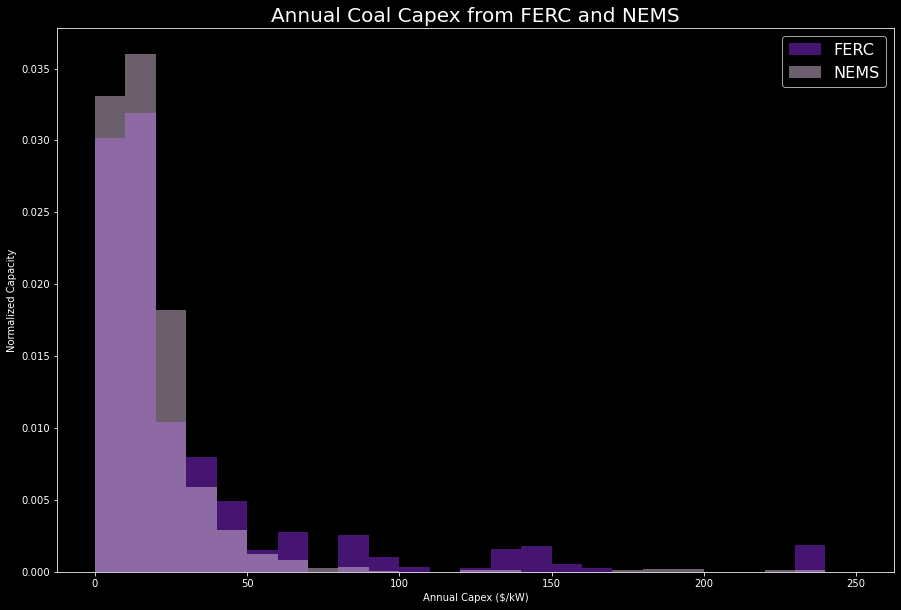

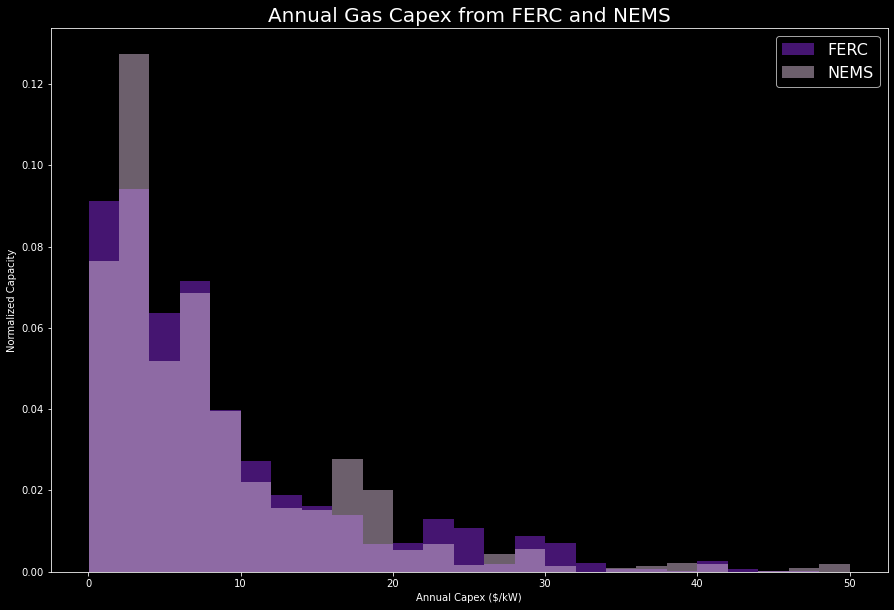

In [10]:
coal_df = out_pudl_units[
    (out_pudl_units.fuel_type_code_pudl == 'coal') 
    & (out_pudl_units.report_date.dt.year.isin(NEMS_FILE_NAMES.keys()))
]


plt.hist(
    coal_df.capex_annual_per_kw_avg_life,
    weights=coal_df.capacity_mw,
    bins=25,
    range=(0, 250),
    label='FERC',
    color='blueviolet',
    density=True,
    alpha=0.5,
)
plt.hist(
    coal_df.capex_annual_per_kw_nems,
    weights=coal_df.capacity_mw,
    bins=25,
    range=(0, 250),
    label='NEMS',
    color='thistle',
    density=True,
    alpha=0.5,
)

plt.ylabel('Normalized Capacity')
plt.xlabel('Annual Capex ($/kW)')
plt.legend(fontsize=16)
plt.title('Annual Coal Capex from FERC and NEMS', fontsize=20)
plt.show();



gas_df = out_gem_units[
    (out_gem_units.fuel_type_code_pudl == 'gas') 
    & (out_gem_units.report_date.dt.year.isin(NEMS_FILE_NAMES.keys()))
]


plt.hist(
    gas_df.capex_annual_per_kw_avg_life,
    weights=gas_df.capacity_mw,
    bins=25,
    range=(0.01, 50),
    label='FERC',
    color='blueviolet',
    density=True,
    alpha=0.5,
)
plt.hist(
    gas_df.capex_annual_per_kw_nems,
    weights=gas_df.capacity_mw,
    bins=25,
    range=(0.01, 50),
    label='NEMS',
    color='thistle',
    density=True,
    alpha=0.5,
)

plt.ylabel('Normalized Capacity')
plt.xlabel('Annual Capex ($/kW)')
plt.legend(fontsize=16)
plt.title('Annual Gas Capex from FERC and NEMS', fontsize=20)
plt.show();

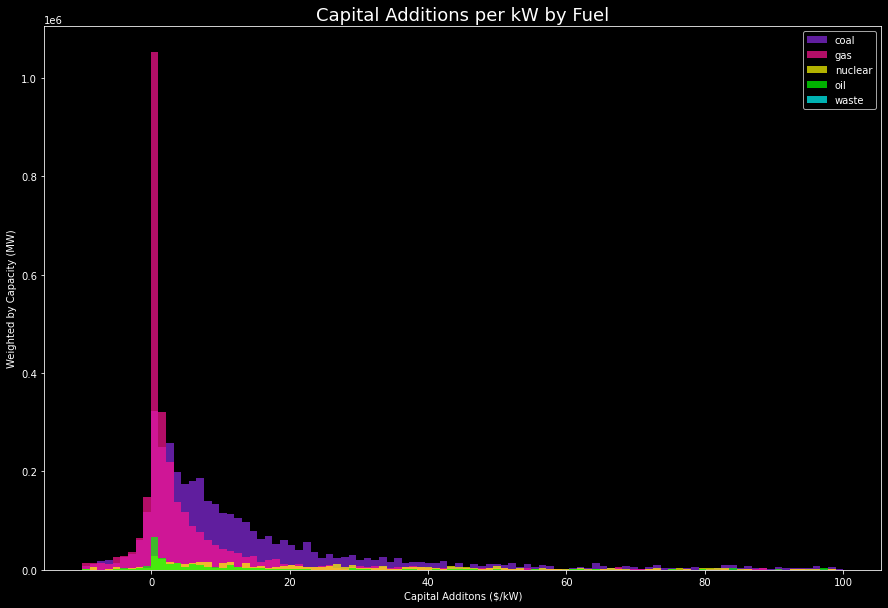

In [11]:
colors_fuel = ['blueviolet', 'deeppink', 'yellow', 'lime', 'aqua', ]
fuels= [f for f in steam_df.fuel_type_code_pudl.unique() if f not in ['unknown', ''] and f is not np.NAN]

for fuel, color in zip(fuels, colors_fuel):
    df = steam_df[steam_df.fuel_type_code_pudl == fuel]
    plt.hist(
        df.capex_annual_per_mw/1000,
        weights=df.capacity_mw,
        bins=100, range=(-10, 100),
        label=fuel,
        alpha=.7, color=color
    )
    
plt.title('Capital Additions per kW by Fuel', fontsize=18)
plt.xlabel('Capital Additons ($/kW)')
plt.ylabel('Weighted by Capacity (MW)')
plt.legend()
plt.show()

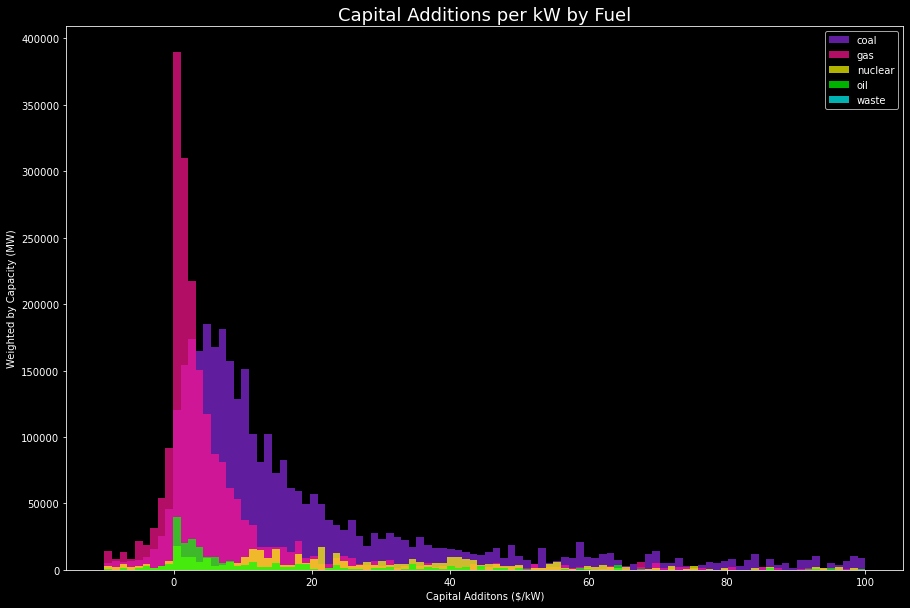

In [12]:
for fuel, color in zip(fuels, colors_fuel):
    df = steam_df[steam_df.fuel_type_code_pudl == fuel]
    plt.hist(
        df.capex_annual_per_mw_rolling/1000,
        weights=df.capacity_mw,
        bins=100, range=(-10, 100),
        label=fuel,
        alpha=.7, color=color
    )
    
plt.title('Capital Additions per kW by Fuel', fontsize=18)
plt.xlabel('Capital Additons ($/kW)')
plt.ylabel('Weighted by Capacity (MW)')
plt.legend()
plt.show()

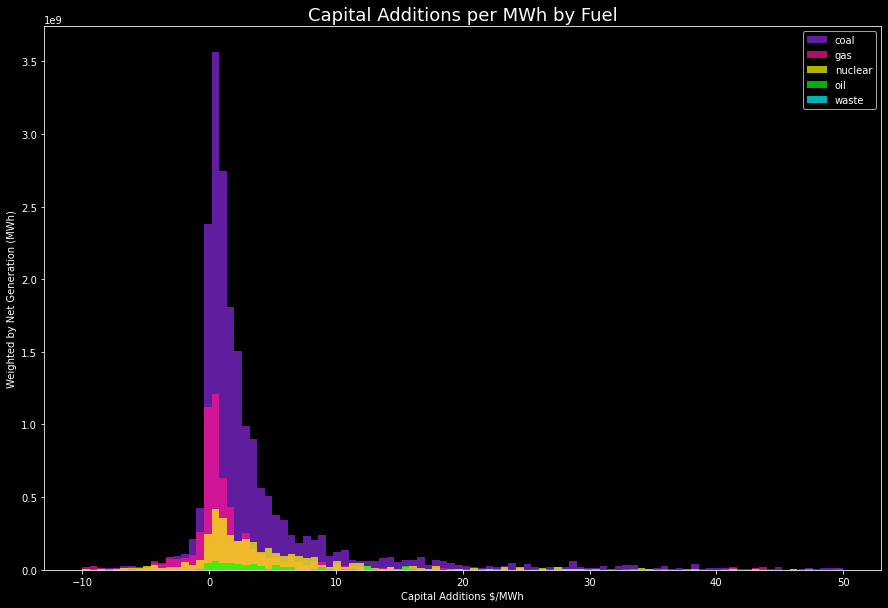

In [13]:
for fuel, color in zip(fuels, colors_fuel):
    df = steam_df[steam_df.fuel_type_code_pudl == fuel]
    plt.hist(
        df.capex_annual_per_mwh,
        weights=df.net_generation_mwh,
        bins=100, range=(-10, 50),
        label=fuel,
        alpha=.7,
        color=color
    )
    
plt.title('Capital Additions per MWh by Fuel', fontsize=18)
plt.xlabel('Capital Additions $/MWh')
plt.ylabel('Weighted by Net Generation (MWh)')
plt.legend()
plt.show()

### Charting the different FERC methods

In [14]:
unit = agg_gen_eia_to_unit(gen=gen, unit_id_col='unit_id_pudl')

Aggergating the generators to a unit level. This takes some minutes.


In [15]:
unit_id_col = 'unit_id_pudl'

eia_ferc_fuel = merge_eia_ferc_simple(unit=unit, steam_df=steam_df, unit_id_col=unit_id_col)

gens_w_ferc1 = (
    merge_eia_ferc(
        gen=gen,
        steam_df=steam_df,
        unit_id_col=unit_id_col,
        unit=unit,
        debug=True
    )
    .pipe(fill_in_opex_w_nems)
    .pipe(add_lifetime_avg_capex, unit_id_col)
    .pipe(add_state_fuel_avg)
)

21.00% of steam records match with one unit


/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


We have 64% of capacity assocaited with annual capex, which is 53% of the total records.


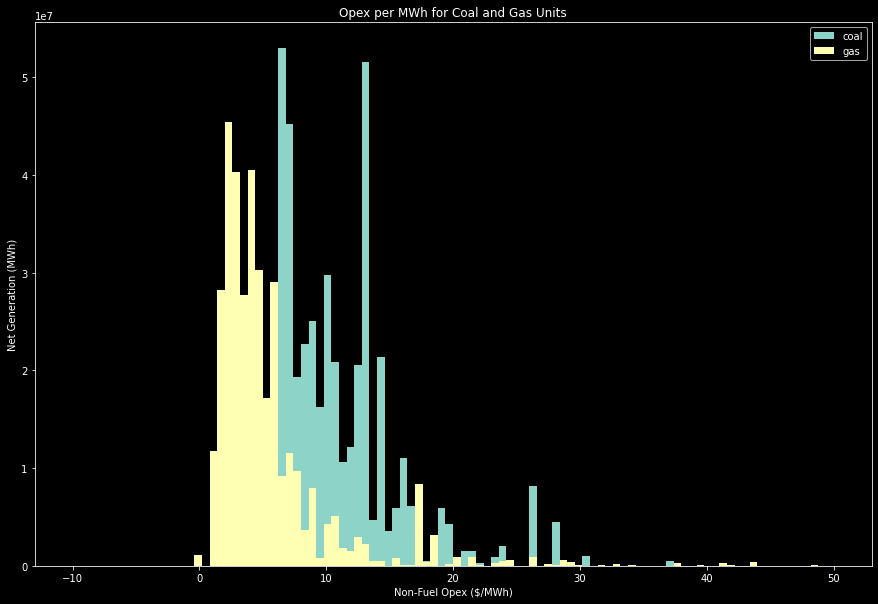

In [16]:
for fuel in ['coal', 'gas']:
    fuel_df = eia_ferc_fuel[
        (eia_ferc_fuel.fuel_type_code_pudl == fuel)
        & (eia_ferc_fuel.report_date.dt.year == 2019)
    ]
    plt.hist(
        fuel_df.opex_nonfuel_per_mwh, 
        weights=fuel_df.net_generation_mwh,
        range=(-10,50),
        bins=100,
        label=fuel
    )
plt.xlabel("Non-Fuel Opex ($/MWh)")
plt.ylabel("Net Generation (MWh)")
plt.legend()
plt.title("Opex per MWh for Coal and Gas Units")
plt.show()


In [17]:
non_matching = gens_w_ferc1[
    (gens_w_ferc1.opex_nonfuel_per_mwh_plant_fuel !=
    gens_w_ferc1.opex_nonfuel_per_mwh_unit)
    & gens_w_ferc1.opex_nonfuel_per_mwh_plant_fuel.notnull()
    & gens_w_ferc1.opex_nonfuel_per_mwh_unit.notnull()
]

Text(0.5, 1.0, 'Non-Fuel Opex plant_fuel vs. plant_unit (Non-matching)')

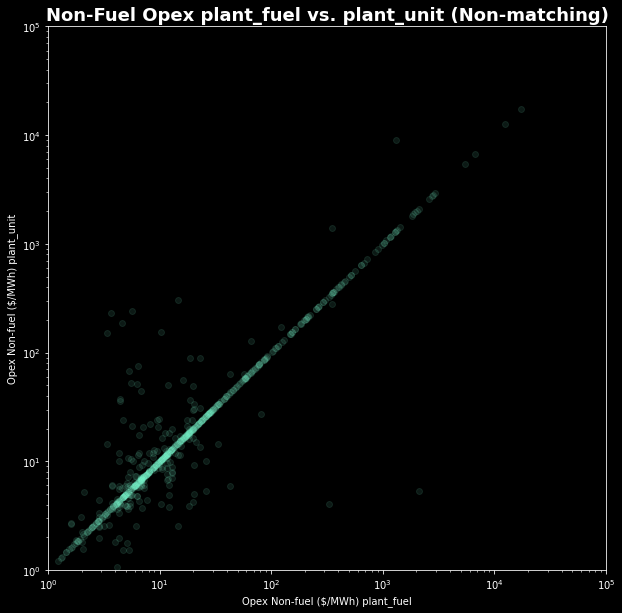

In [18]:
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.scatter(non_matching.opex_nonfuel_per_mwh_plant_fuel,
           non_matching.opex_nonfuel_per_mwh_unit,
           color='aquamarine', alpha=0.1, 
           #label=field
          )
lims = (1e0, 1e5)
ax.set_ylim(lims)
ax.set_xlim(lims)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Opex Non-fuel ($/MWh) plant_fuel')
ax.set_ylabel('Opex Non-fuel ($/MWh) plant_unit')
ax.set_title(f"Non-Fuel Opex plant_fuel vs. plant_unit (Non-matching)", {'fontsize': 18,'fontweight' : 'bold'})

Text(0.5, 1.0, 'Non-Fuel Opex plant_fuel vs. plant_unit (Non-matching)')

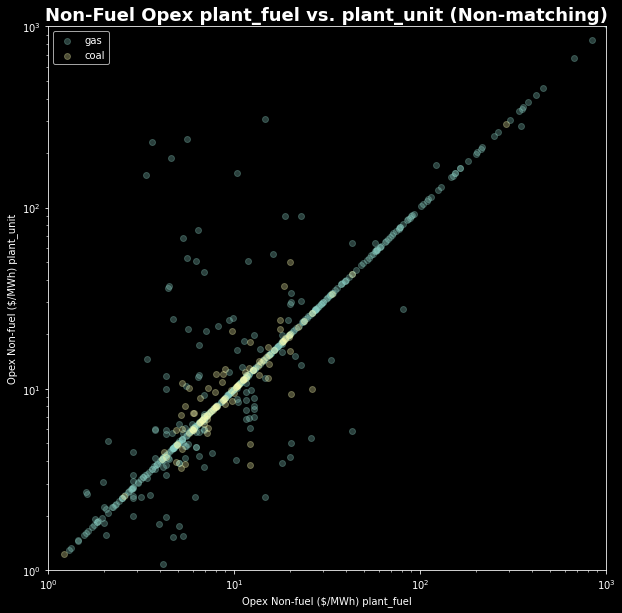

In [19]:
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
for fuel_type in ['gas', 'coal']:
    non_matching_fuel = non_matching[non_matching.fuel_type_code_pudl == fuel_type]
    ax.scatter(non_matching_fuel.opex_nonfuel_per_mwh_plant_fuel,
               non_matching_fuel.opex_nonfuel_per_mwh_unit,
               #color='aquamarine',
               alpha=0.3, 
               label=fuel_type
              )
    lims = (1e0, 1e3)
ax.set_ylim(lims)
ax.set_xlim(lims)
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Opex Non-fuel ($/MWh) plant_fuel')
ax.set_ylabel('Opex Non-fuel ($/MWh) plant_unit')
ax.set_title(f"Non-Fuel Opex plant_fuel vs. plant_unit (Non-matching)", {'fontsize': 18,'fontweight' : 'bold'})

Text(0.5, 1.0, 'Non-Fuel Opex plant_fuel vs. plant_unit 2019 (Non-matching)')

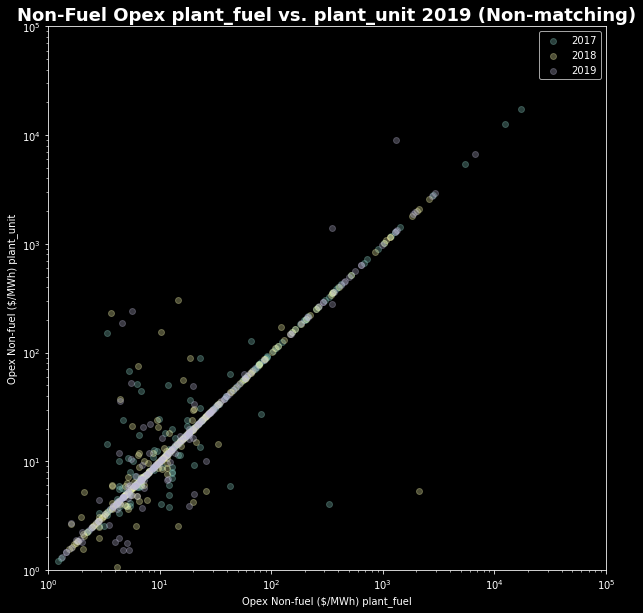

In [20]:
fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
#for year in non_matching.report_date.sort_values().dt.year.unique():
for year in [2017,2018,2019]:
    non_matching_year = non_matching[non_matching.report_date.dt.year == year]
    ax.scatter(non_matching_year.opex_nonfuel_per_mwh_plant_fuel,
               non_matching_year.opex_nonfuel_per_mwh_unit,
               #color='aquamarine',
               alpha=0.3, 
               label=year
              )
    lims = (1e0, 1e5)
ax.set_ylim(lims)
ax.set_xlim(lims)
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Opex Non-fuel ($/MWh) plant_fuel')
ax.set_ylabel('Opex Non-fuel ($/MWh) plant_unit')
ax.set_title(f"Non-Fuel Opex plant_fuel vs. plant_unit {year} (Non-matching)", {'fontsize': 18,'fontweight' : 'bold'})